## Cats vs Dogs classifier for real image dataset

### Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
from PIL import Image
from IPython.display import display

# Filter harmless warnings
import warnings
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\envs\project\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


In [2]:
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"The device is: {device}")

The device is: cuda


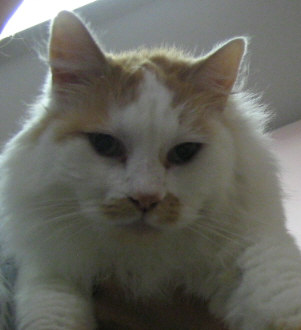

In [3]:
#Check for dataset path 
with Image.open('data/CATS_DOGS/test/CAT/9497.jpg') as im:
    display(im)

### List of image filenames

In [4]:
path = 'data\\CATS_DOGS\\'
img_names = []

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+'\\'+img)
        
print('Images: ',len(img_names))

Images:  24994


### DataFrame of image sizes

As the (width x height) of images are different. Analysis of image size is important for processing operations

In [5]:
img_sizes = []
rejected = []   # incase ny image fails to open

for item in img_names:
    try:
        with Image.open(item) as img:
            img_sizes.append(img.size)
    except:
        rejected.append(item)

# A dataframe of image sizes 
df = pd.DataFrame(img_sizes)

print(f'Images:  {len(img_sizes)}')
print(f'Rejects: {len(rejected)}')

Images:  24994
Rejects: 0


In [6]:
# df[0] contains image widths
df[0].describe()

count    24994.000000
mean       404.493518
std        108.941802
min         42.000000
25%        323.000000
50%        448.000000
75%        500.000000
max        500.000000
Name: 0, dtype: float64

In [7]:
# df[1] contains image heights
df[1].describe()

count    24994.000000
mean       361.037129
std         96.936811
min         33.000000
25%        302.000000
50%        375.000000
75%        421.000000
max        500.000000
Name: 1, dtype: float64

### Image Transformations

Goal is to resize all images (train and test sets) into common size of (3, 224, 224) <> (channel, width, height)

This way we can have common input shape to our networks

In [8]:
'''
Input: .jpg (PIL image) with pixel range [0, 255]
Output: torch.FloatTensor 
'''

train_transform = transforms.Compose([
        transforms.RandomRotation(15),      # rotate +/- 15 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], #the mean and std values are chosen upon google search. 
                             [0.229, 0.224, 0.225]) #In pratice other values can also be choosen
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

Check the output of train_transform

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<built-in method size of Tensor object at 0x0000022A21460368>


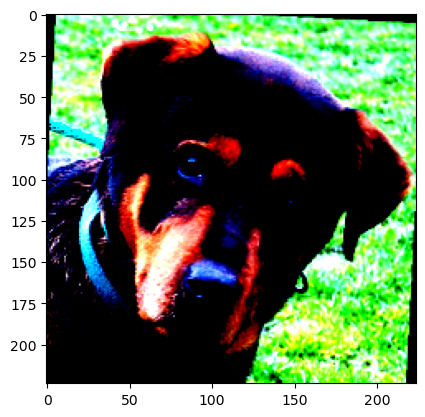

In [9]:
dog = Image.open('data\\CATS_DOGS\\train\\DOG\\67.jpg')
dog_transform = train_transform(dog)
print(dog_transform.size)
plt.imshow(np.transpose(dog_transform.numpy(), (1, 2, 0)));

Check the output of test_transform

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<built-in method size of Tensor object at 0x0000022A27E36598>


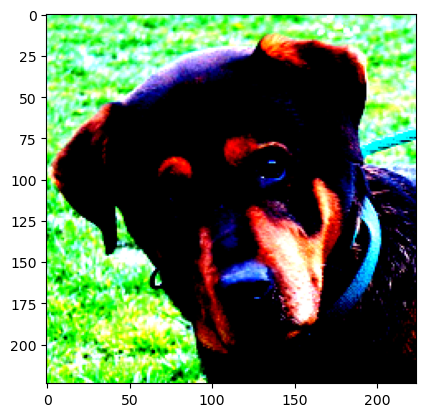

In [10]:
dog = Image.open('data\\CATS_DOGS\\train\\DOG\\67.jpg')
dog_transform = test_transform(dog)
print(dog_transform.size)
plt.imshow(np.transpose(dog_transform.numpy(), (1, 2, 0)));

### Dataloaders

In [11]:
path = 'data/CATS_DOGS'

train_data_unsplit = datasets.ImageFolder(os.path.join(path, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(path, 'test'), transform=test_transform)

val_data, train_data = torch.utils.data.random_split(train_data_unsplit, [3743, 15000])
torch.manual_seed(42)

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
val_loader = DataLoader(val_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

class_names = test_data.classes

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['CAT', 'DOG']
Training images available: 15000
Testing images available:  6251


Label: [1 1 1 0 1 0 1 1 0 0]
Class: DOG DOG DOG CAT DOG CAT DOG DOG CAT CAT


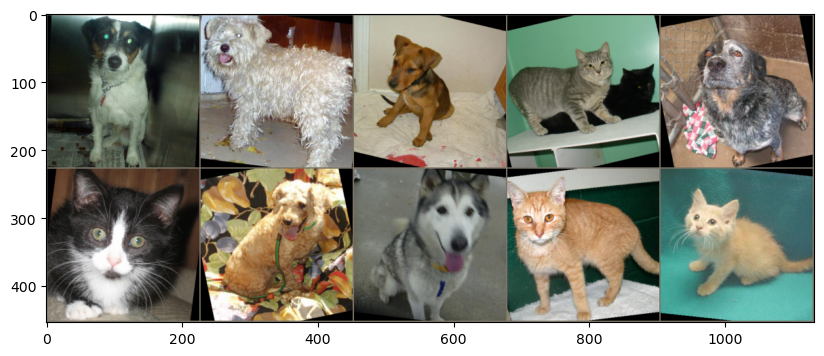

In [12]:
# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

### Function Definitions

In [13]:
## Training Functions

def get_accuracy(pred, labels):
    total = 0
    correct = 0 
    labels , pred = labels.cpu() , pred.cpu()
    _,predicted = torch.max(pred , 1)
    total += len(labels.numpy())
    correct += ((predicted == labels).numpy()).sum()
    return correct/total

def validate(model, valoader, criterion, max_val_batch):
    val_loss = 0
    val_accuracy = 0
    model.eval()
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            if batch_idx == max_val_batch:
                break
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            accuracy = get_accuracy(outputs, targets)
            val_accuracy += accuracy
        avg_loss = val_loss/(batch_idx+1)
        avg_acc = val_accuracy/(batch_idx+1)
    return avg_loss, avg_acc
    
    
def train_one_epoch(model, trainloader, optimizer, criterion, max_trn_batch):
    model.train()
    train_loss = 0
    train_accuracy = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        if batch_idx == max_trn_batch:
            break
        batch_idx+=1
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        accuracy = get_accuracy(outputs, targets)
        train_accuracy += accuracy
    avg_train_loss = train_loss/(batch_idx+1)
    avg_train_acc = train_accuracy/(batch_idx+1)
    return avg_train_loss, avg_train_acc, model 

def test_accuracy(model, test_loader):
    correct = 0 # number of correct predictions
    total   = 0 # number of samples in test set

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels =images.to(device), labels.to(device)
            model.eval()
            outputs = model(images)
            _, predicted = torch.max(outputs.data , 1)
            total += labels.size(0)
            correct += ((predicted.cpu() == labels.cpu()).numpy()).sum()
    print(f"Accuracy of the network on test set:{100*correct/total:.5}%")
    return correct, total

def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>9}')
    print(f'_________\n{sum(params):>9}{" <- Total trainable parameters"}')
    

In [14]:
## Plot Functions

def plot_accuracy(epochs, acc_train, acc_val, network_name = "default"):
    plt.plot(epochs,acc_train, 'r-',label='Train Accuracy')
    plt.plot(epochs,acc_val, 'g-',label='Val Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f'Train accuracy and validation accuracy -- {network_name}')
    plt.legend();

def plot_loss(epochs, loss_train, loss_val, network_name = "default"):
    plt.plot(epochs, loss_train, 'r-',label='Train Loss')
    plt.plot(epochs, loss_val, 'g-',label='Val Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Train loss and validation loss -- {network_name}")
    plt.legend();

### Custom Network

In [15]:
class CustomNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 6, 3, 1)
        self.conv3 = nn.Conv2d(6, 9, 3, 1)
        self.conv4 = nn.Conv2d(9, 12, 3, 1)
        self.fc1 = nn.Linear(53*53*12, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 53*53*12)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)
    
    def count_parameters(self):
        params = [p.numel() for p in self.parameters() if p.requires_grad]
        for item in params:
            print(f'{item:>7}')
        print(f'_______\n{sum(params):>7}{" <- Total trainable parameters"}')

Defining criterion and optimizer

In [16]:
torch.manual_seed(101)
custom_model = CustomNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(custom_model.parameters(), lr=0.001)
custom_model

CustomNet(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(6, 9, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(9, 12, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=33708, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [17]:
custom_model.count_parameters()

    162
      6
    324
      6
    486
      9
    972
     12
4044960
    120
  10080
     84
    168
      2
_______
4057391 <- Total trainable parameters


### Training

In [18]:
import time
start_time = time.time()

max_trn_batch = 800            #Limiting no of training batches to 800
max_val_batch = 300            #Limiting no of testing batches to 300
epoch_range = 50
epochs     = []
loss_train = []
acc_train  = []
loss_val   = []
acc_val   = []
for epoch in range(epoch_range):
    train_loss, train_acc, custom_model = train_one_epoch(custom_model, train_loader,
                                        optimizer, criterion, max_trn_batch)
    val_loss, val_acc = validate(custom_model, test_loader, criterion, max_val_batch)
    
    message = print(f'Epoch: {epoch+1} Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}')
    
    print(message)
    
    epochs.append(epoch)
    loss_train.append(train_loss)
    loss_val.append(val_loss)
    acc_train.append(train_acc)
    acc_val.append(val_acc)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') 

Epoch: 1 Train Loss: 0.6796 Train Acc: 0.5567 Val Loss: 0.6389 Val Acc: 0.6070
None
Epoch: 2 Train Loss: 0.6318 Train Acc: 0.6232 Val Loss: 0.6262 Val Acc: 0.6601
None
Epoch: 3 Train Loss: 0.5912 Train Acc: 0.6790 Val Loss: 0.5671 Val Acc: 0.6904
None
Epoch: 4 Train Loss: 0.5694 Train Acc: 0.6998 Val Loss: 0.5618 Val Acc: 0.7086
None
Epoch: 5 Train Loss: 0.5212 Train Acc: 0.7402 Val Loss: 0.5032 Val Acc: 0.7449
None
Epoch: 6 Train Loss: 0.4955 Train Acc: 0.7625 Val Loss: 0.5094 Val Acc: 0.7551
None
Epoch: 7 Train Loss: 0.4756 Train Acc: 0.7727 Val Loss: 0.4667 Val Acc: 0.7684
None
Epoch: 8 Train Loss: 0.4638 Train Acc: 0.7818 Val Loss: 0.4596 Val Acc: 0.7841
None
Epoch: 9 Train Loss: 0.4503 Train Acc: 0.7874 Val Loss: 0.4455 Val Acc: 0.7904
None
Epoch: 10 Train Loss: 0.4314 Train Acc: 0.8035 Val Loss: 0.4446 Val Acc: 0.7953
None
Epoch: 11 Train Loss: 0.4230 Train Acc: 0.8094 Val Loss: 0.4037 Val Acc: 0.8126
None
Epoch: 12 Train Loss: 0.4258 Train Acc: 0.8067 Val Loss: 0.4369 Val Acc: 0

### Save the trained model

In [19]:
# torch.save(custom_model.state_dict(), 'CustomImageModel.pt')

### Plot the results

Plotting accuracy vs epoch for Custom Network

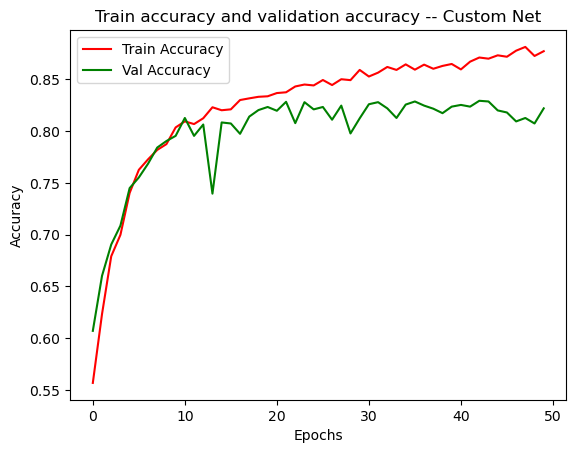

In [20]:
plot_accuracy(epochs, acc_train, acc_val, network_name = "Custom Net")

Plotting loss vs epoch for Custom Network

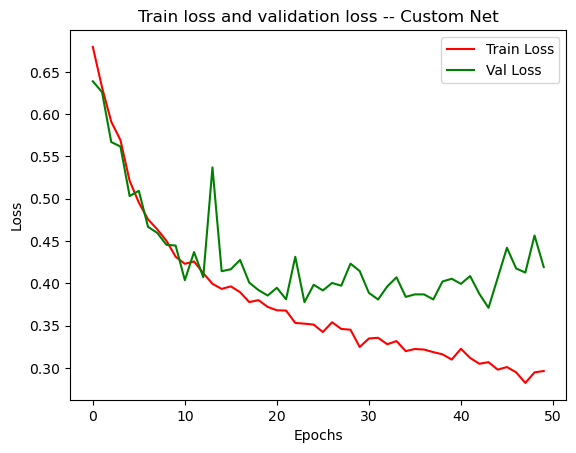

In [21]:
plot_loss(epochs, loss_train, loss_val, network_name = "Custom Net")

Evaluation on test set

In [22]:
correct, total = test_accuracy(custom_model, test_loader)

Accuracy of the network on test set:82.435%


## Comparison of custom network with ResNet-18

### Transfer Learning Method 1: Finetuning the complete ResNet-18 network with this dataset

The goal is to use one of the larger models which is pretrained on ImageNet database.

In [23]:
resnet18 = models.resnet18(pretrained=True)

In [24]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
count_parameters(resnet18)

     9408
       64
       64
    36864
       64
       64
    36864
       64
       64
    36864
       64
       64
    36864
       64
       64
    73728
      128
      128
   147456
      128
      128
     8192
      128
      128
   147456
      128
      128
   147456
      128
      128
   294912
      256
      256
   589824
      256
      256
    32768
      256
      256
   589824
      256
      256
   589824
      256
      256
  1179648
      512
      512
  2359296
      512
      512
   131072
      512
      512
  2359296
      512
      512
  2359296
      512
      512
   512000
     1000
_________
 11689512 <- Total trainable parameters


In [26]:
# modifying the fully connected layer 
fc_in = resnet18.fc.in_features
resnet18.fc = nn.Linear(fc_in, 2)

In [27]:
resnet18 = resnet18.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=1e-3)

Training ResNet-18

In [28]:
import time
start_time = time.time()

max_trn_batch = 800            #Limiting no of training batches to 800
max_val_batch = 300            #Limiting no of testing batches to 300
epoch_range = 50
epochs     = []
loss_train = []
acc_train  = []
loss_val   = []
acc_val   = []
for epoch in range(epoch_range):
    train_loss, train_acc, resnet18 = train_one_epoch(resnet18, train_loader,
                                        optimizer, criterion, max_trn_batch)
    val_loss, val_acc = validate(resnet18, test_loader, criterion, max_val_batch)
    
    message = print(f'Epoch: {epoch+1} Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}')
    
    print(message)
    
    epochs.append(epoch)
    loss_train.append(train_loss)
    loss_val.append(val_loss)
    acc_train.append(train_acc)
    acc_val.append(val_acc)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') 

Epoch: 1 Train Loss: 0.3655 Train Acc: 0.8482 Val Loss: 0.2911 Val Acc: 0.8684
None
Epoch: 2 Train Loss: 0.2615 Train Acc: 0.8945 Val Loss: 0.5036 Val Acc: 0.7983
None
Epoch: 3 Train Loss: 0.2470 Train Acc: 0.9010 Val Loss: 0.2361 Val Acc: 0.8904
None
Epoch: 4 Train Loss: 0.2240 Train Acc: 0.9080 Val Loss: 0.1530 Val Acc: 0.9296
None
Epoch: 5 Train Loss: 0.1839 Train Acc: 0.9270 Val Loss: 0.1730 Val Acc: 0.9269
None
Epoch: 6 Train Loss: 0.1827 Train Acc: 0.9217 Val Loss: 0.1368 Val Acc: 0.9405
None
Epoch: 7 Train Loss: 0.1537 Train Acc: 0.9332 Val Loss: 0.1607 Val Acc: 0.9272
None
Epoch: 8 Train Loss: 0.1525 Train Acc: 0.9378 Val Loss: 0.1592 Val Acc: 0.9355
None
Epoch: 9 Train Loss: 0.1443 Train Acc: 0.9395 Val Loss: 0.1283 Val Acc: 0.9392
None
Epoch: 10 Train Loss: 0.1365 Train Acc: 0.9441 Val Loss: 0.1865 Val Acc: 0.9166
None
Epoch: 11 Train Loss: 0.1286 Train Acc: 0.9477 Val Loss: 0.1135 Val Acc: 0.9492
None
Epoch: 12 Train Loss: 0.1283 Train Acc: 0.9482 Val Loss: 0.1301 Val Acc: 0

Plotting accuracy vs epoch for ResNet-18

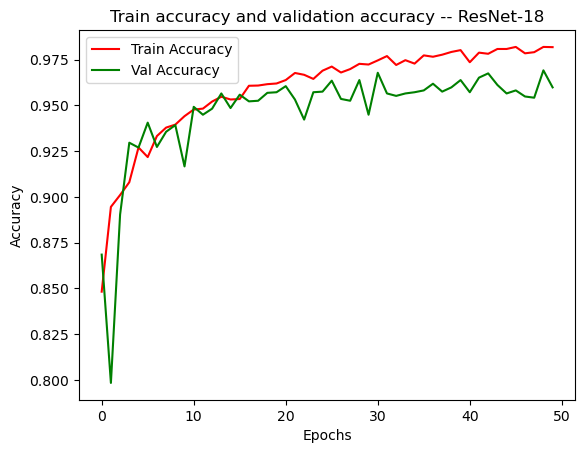

In [29]:
plot_accuracy(epochs, acc_train, acc_val, network_name = "ResNet-18")

Plotting loss vs epoch for ResNet-18

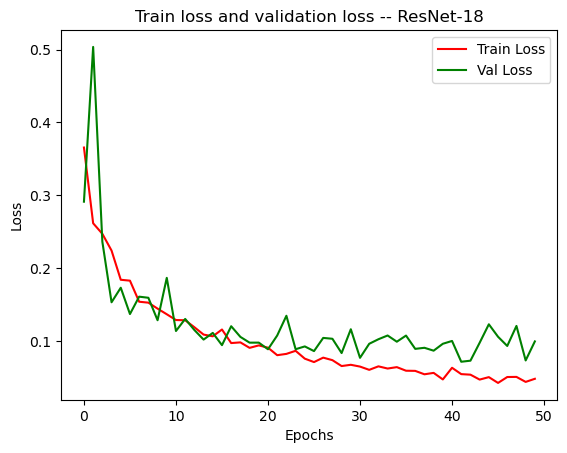

In [30]:
plot_loss(epochs, loss_train, loss_val, network_name = "ResNet-18")

Evaluation on test set

In [31]:
correct, total = test_accuracy(resnet18, test_loader)

Accuracy of the network on test set:96.161%


### Transfer Learning Method 2: Train ResNet-18 network by freezing ConvNet weights and train only FC layer

The goal is to use one of the larger models which is pretrained on ImageNet database.

The ImageNet database has 1000 categories. But our dataset has only 2 categories. So I will freeze all the layers except the final layer and train the model with just 2 neurons in the final layer

In [32]:
# importing resnet18 from torchvision with pretrained weights
resnet18_pretrained = models.resnet18(pretrained=True)

In [33]:
# freezing weights in all the layers
for param in resnet18_pretrained.parameters():
    param.requires_grad = False

# modifying the fully connected layer 
fc_in = resnet18_pretrained.fc.in_features
resnet18_pretrained.fc = nn.Linear(fc_in, 2)

In [34]:
resnet18_pretrained = resnet18_pretrained.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18_pretrained.fc.parameters(), lr=1e-3)

In [35]:
import time
start_time = time.time()

max_trn_batch = 800            #Limiting no of training batches to 800
max_val_batch = 300            #Limiting no of testing batches to 300
epoch_range = 50
epochs     = []
loss_train = []
acc_train  = []
loss_val   = []
acc_val   = []
for epoch in range(epoch_range):
    train_loss, train_acc, resnet18_pretrained = train_one_epoch(resnet18_pretrained, train_loader,
                                        optimizer, criterion, max_trn_batch)
    val_loss, val_acc = validate(resnet18_pretrained, test_loader, criterion, max_val_batch)
    
    message = print(f'Epoch: {epoch+1} Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}')
    
    print(message)
    
    epochs.append(epoch)
    loss_train.append(train_loss)
    loss_val.append(val_loss)
    acc_train.append(train_acc)
    acc_val.append(val_acc)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') 

Epoch: 1 Train Loss: 0.2065 Train Acc: 0.9139 Val Loss: 0.0747 Val Acc: 0.9684
None
Epoch: 2 Train Loss: 0.1503 Train Acc: 0.9396 Val Loss: 0.0735 Val Acc: 0.9691
None
Epoch: 3 Train Loss: 0.1653 Train Acc: 0.9325 Val Loss: 0.0527 Val Acc: 0.9784
None
Epoch: 4 Train Loss: 0.1484 Train Acc: 0.9391 Val Loss: 0.0531 Val Acc: 0.9744
None
Epoch: 5 Train Loss: 0.1341 Train Acc: 0.9467 Val Loss: 0.0580 Val Acc: 0.9754
None
Epoch: 6 Train Loss: 0.1528 Train Acc: 0.9377 Val Loss: 0.0720 Val Acc: 0.9674
None
Epoch: 7 Train Loss: 0.1289 Train Acc: 0.9479 Val Loss: 0.0690 Val Acc: 0.9708
None
Epoch: 8 Train Loss: 0.1425 Train Acc: 0.9428 Val Loss: 0.0542 Val Acc: 0.9757
None
Epoch: 9 Train Loss: 0.1416 Train Acc: 0.9438 Val Loss: 0.0562 Val Acc: 0.9744
None
Epoch: 10 Train Loss: 0.1313 Train Acc: 0.9466 Val Loss: 0.0536 Val Acc: 0.9761
None
Epoch: 11 Train Loss: 0.1624 Train Acc: 0.9358 Val Loss: 0.0689 Val Acc: 0.9724
None
Epoch: 12 Train Loss: 0.1244 Train Acc: 0.9487 Val Loss: 0.0590 Val Acc: 0

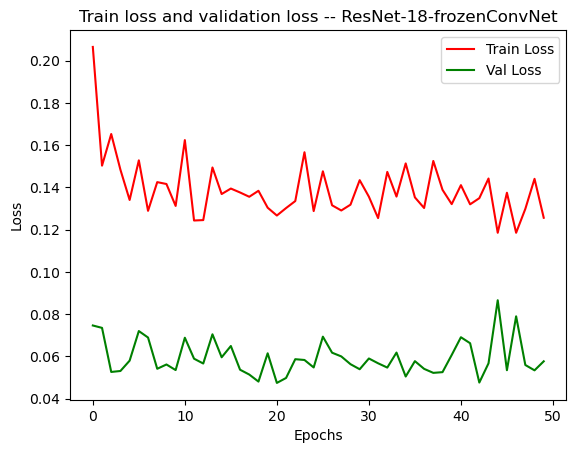

In [36]:
plot_loss(epochs, loss_train, loss_val, network_name = "ResNet-18-frozenConvNet")

In [37]:
## Evaluation on test set

correct, total = test_accuracy(resnet18_pretrained, test_loader)

Accuracy of the network on test set:97.632%
